In [1]:
# import pprint
# import sys

# pprint.pprint(sys.path)

In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import os
import sys
sys.path.append('/mnt/c/Users/44yos/RacePrediction/resnet_win5')
from os import path
import time
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE

import tensorflow as tf
# from tensorflow.python import keras
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils import np_utils
# from tensorflow.python.keras import regularizers
# from tensorflow.python.keras.models import load_model
# tf.config.run_functions_eagerly(True)

import matplotlib.pyplot as plt 
# from scipy.stats import norm

from pickle import dump

# from models import resnet
from models import transformer

In [3]:
# load data
data = pd.read_csv("../data/csv/data.csv", sep = ",")
print(data.dtypes)

race_id                        int64
race_round                     int64
ground_condition               int64
total_horse_number             int64
order                          int64
frame_number                   int64
horse_number                   int64
age                            int64
burden_weight                float64
goal_time                    float64
half_order                   float64
last_time                    float64
odds                         float64
pop                          float64
horse_weight                 float64
race_rank                      int64
distance                       int64
ground_type_ダ                  int64
ground_type_芝                  int64
circle_右                       int64
circle_左                       int64
weather_circumstance_小雨        int64
weather_circumstance_小雪        int64
weather_circumstance_晴         int64
weather_circumstance_曇         int64
weather_circumstance_雨         int64
weather_circumstance_雪         int64
p

In [4]:
# adjust columns type
data['race_id'] = data['race_id'].astype(str)
# data['race_round'] = data['race_round'].astype(str)
# #data['total_horse_number'] = data['total_horse_number'].astype(str)
data['order'] = data['order'].astype(str)
# data['frame_number'] = data['frame_number'].astype(str)
# data['horse_number'] = data['horse_number'].astype(str)


In [5]:
# delete race day information
data = data.drop(["horse_number", "half_order", "goal_time" ,"last_time", "horse_weight", "horse_weight_dif", "frame_number","pop"], axis = 1)
# "race_round",

In [6]:
# standarlization 
no_scale_data = data[['race_id','order']]
scale_columns = data.drop(['race_id','order'], axis=1).columns.values
standard_scale = StandardScaler()
data = pd.DataFrame(standard_scale.fit_transform(data[scale_columns]))
data = pd.concat([data, no_scale_data], axis=1)
dump(standard_scale, open("standard_scale.pkl", "wb"))

In [7]:
# # creating time series data
# def return_one_race(all_horse):
#     print(len(all_horse))
#     one_race = np.full((18, 139), -float('inf'))
# #     print(len(one_race))
# #     print(len(one_race[0]))
#     for i, one_horse in all_horse.iterrows():
#         print(i)
# #         print(one_horse)
#         one_race[i] = one_horse.drop(['race_id']).values
#     print(one_race)
#     return one_race

# def create_time_series_data(raw_data):
#     time_series_data = []
#     time_series_data.append(raw_data.groupby(['race_id']).apply(return_one_race))
#     return time_series_data

In [8]:
print(data.shape)
print(data.dtypes)
print(data.head(20))

(92033, 142)
0          float64
1          float64
2          float64
3          float64
4          float64
5          float64
6          float64
7          float64
8          float64
9          float64
10         float64
11         float64
12         float64
13         float64
14         float64
15         float64
16         float64
17         float64
18         float64
19         float64
20         float64
21         float64
22         float64
23         float64
24         float64
25         float64
26         float64
27         float64
28         float64
29         float64
30         float64
31         float64
32         float64
33         float64
34         float64
35         float64
36         float64
37         float64
38         float64
39         float64
40         float64
41         float64
42         float64
43         float64
44         float64
45         float64
46         float64
47         float64
48         float64
49         float64
50         float64
51         float64

In [9]:
def create_time_series_data(raw_data):
    number_of_race = raw_data.race_id.nunique()
    time_series_data = np.full((number_of_race, 18, 140), -float('inf'))
    label = np.full((number_of_race, 18), 19)
    race_number = 0
    horse_number = 0
    for i in range(len(raw_data)):
        if i == 0:
#             print(race_number)
#             print(horse_number)
#             print(raw_data.iloc[i].order)
            label[race_number][horse_number] = float(raw_data.iloc[i].order)
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
            continue
        if data.iloc[i].race_id != data.iloc[i-1].race_id:
            race_number += 1
            horse_number = 0
            label[race_number][horse_number] = float(raw_data.iloc[i].order)
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
        else:
            label[race_number][horse_number] = float(raw_data.iloc[i].order)
            time_series_data[race_number][horse_number] = raw_data.iloc[i].drop(['race_id','order'])
            horse_number += 1
    return time_series_data, label

In [10]:
X, y_order = create_time_series_data(data)
print(X.shape)
print(y_order.shape)

(8489, 18, 140)
(8489, 18)


In [11]:
X = X.astype('float32')
print(X.dtype)

float32


In [12]:
print(X[0][11])
print(y_order[0])

[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
[ 5  2 11  7  1  6  3  8  4 12 14 19 19 19 19 19 19 19]


In [13]:
# creating X,y (parameters and target)
y = np_utils.to_categorical(y_order, dtype='float32')
print(y[0])
print(X.shape)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

AxesSubplot(0.125,0.125;0.775x0.755)


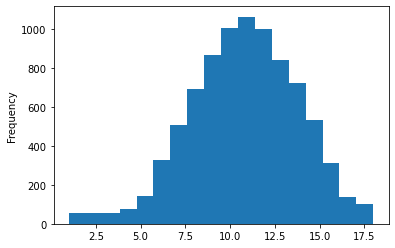

In [14]:
print(data.race_id.value_counts().plot.hist(bins=18,range=(1,18)))

AxesSubplot(0.125,0.125;0.775x0.755)


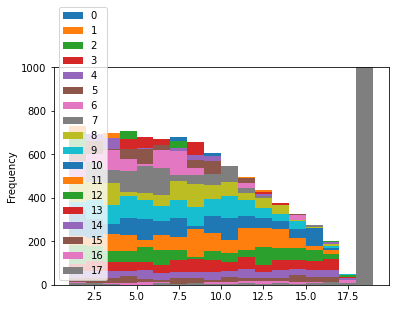

In [15]:
print(pd.DataFrame(y_order).plot.hist(bins=18, ylim=(0,1000)))

In [16]:
# BUFFER_SIZE = 1000
# BATCH_SIZE = 128
# def make_batches(ds):
#     return (
#       ds
# #       .cache()
# #       .shuffle(BUFFER_SIZE)
#       .batch(BATCH_SIZE)
# #       .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
#       .prefetch(tf.data.AUTOTUNE))

# X = tf.convert_to_tensor(X)
# y = tf.convert_to_tensor(y)
# X = make_batches(X)
# y = make_batches(y)

In [17]:
# data split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [18]:
print(X_train[0][0])

[-1.3145431  -0.50991476  0.5901306   0.089023    0.3633046  -0.555636
 -0.38537532  0.8550409  -0.7798238   0.7798238   0.6798608  -0.66338956
 -0.18337315 -0.02931084 -1.3091208   1.597206   -0.23655261 -0.02236226
 -0.24513794  2.2255282  -0.4990219  -0.17550196 -0.2203592  -0.25591546
 -0.17979759 -0.49679595 -0.19606745 -0.4557965  -0.22428839 -0.71253043
  0.7906001  -1.1524768  -0.4643385  -1.249982   -0.29165798 -0.1354737
 -0.29401696  0.5838889  -0.4724972   0.4967511  -1.3390157  -0.53560555
  0.6186662   0.98761696  0.8457565  -0.5208136   0.7919285  -1.0952293
  0.4266353   1.6640126  -0.18337315 -0.03058303 -1.3037888   1.5938668
 -0.23864526 -0.02422995 -0.1135239  -0.25064442  2.2850358  -0.487239
 -0.18498135 -0.24115273 -0.26462567 -0.18406838 -0.47511455 -0.2061855
 -0.44352028 -0.37101352 -0.7890041   0.79361564 -0.0526072   0.20228021
 -0.685882   -0.52846843 -0.49079907 -0.6400163   1.0059242   1.368932
 -0.52115315  1.2905855  -1.249058    0.10102149  1.6128289  

In [19]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(6791, 18, 140)
(1698, 18, 140)
(6791, 18, 20)
(1698, 18, 20)


In [20]:
# creating dataset with batch size
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [21]:
# set up parameters
num_layers = 4
d_model = 140
num_heads = 4
d_ffn = 512
pe_input = 18
target_size = 20
dropout_rate = 0.1

In [33]:
# set up model
trans_race = transformer.TransRace(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ffn=d_ffn,
    pe_input=pe_input,
    target_size=target_size,
    rate=dropout_rate,
    dynamic=True,
)

# trans_race.build(input_shape=(None,18,139))
trans_race.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [31]:
history = trans_race.fit(
                        X_train, 
                        y_train,
                        validation_data=([X_valid, y_valid]),
                        batch_size=512,
                        epochs=10,
                        callbacks=[early_stopping],
                        verbose=True, # hide the output because we have so many epochs
                        )
trans_race.save_weights("../models/results/transfomer1.h5")

TypeError: Unrecognized keyword arguments: {'training': True}

In [29]:
# predict

pred = trans_race(X_valid, training=False)
pred = np.array(pred)
Y_pred = np.argmax(pred, axis = 1)
Y_ans = np.argmax(Y_valid, axis = 1)


NotImplementedError: Cannot convert a symbolic Tensor (trans_race_4/StatefulPartitionedCall:0) to a numpy array.

In [ ]:
correct = 0
for i in range(len(Y_pred)):
    if (Y_pred[i] == Y_ans[i]):
        correct += 1
accuracy = correct / len(Y_pred)
print("accuracy: ", accuracy)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    @tf.function
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [25]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

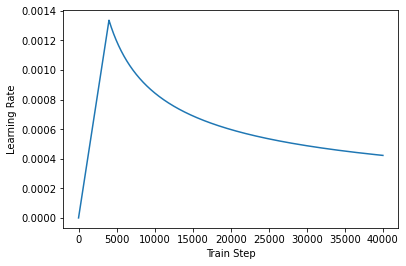

In [26]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)).eval(session=tf.Session()))
# plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)).numpy())
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [27]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

In [28]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 19))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real,pred)

    mask = tf.math.logical_not(tf.math.equal(real, 19))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [29]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [30]:
# checkpoint_path = "./checkpoints/train"

# ckpt = tf.train.Checkpoint(transformer=transformer,
#                            optimizer=optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print('Latest checkpoint restored!!')

In [31]:
EPOCHS = 2

In [32]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, :]

    with tf.GradientTape() as tape:
        predictions = trans_race([inp, tar_inp],
                                     training = True)
        loss = loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, trans_race.trainable_variables)
        optimizer.apply_gradients(zip(gradients, trans_race.trainable_variables))

        train_loss(loss)
        train_accuracy(accuracy_function(tar_real, predictions))

In [33]:
@tf.function
def train_loop():
    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
#         print(batch)
#             print(inp.shape)
#             print(tar.shape)
        inp = tf.convert_to_tensor(inp, np.float32)
        tar = tf.convert_to_tensor(tar, np.float32)
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} ') #Loss {train_loss.result().numpy():.4f} Accuracy {train_accuracy.result().numpy():.4f}
#                 print(train_loss.result(),train_accuracy.result())

        if (epoch + 1) % 5 == 0:
    #         ckpt_save_path = ckpt_manager.save()
    #         print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

#             print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

In [34]:
# sess = tf.Session(config=tf.ConfigProto(
#       allow_soft_placement=True, log_device_placement=True))
with tf.device('gpu:0'):
    for epoch in range(EPOCHS):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()
        
        train_loop()

mask shape after creating (?, 1, 1, ?, ?)
(?, ?, 140) mha
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 4, 18, 35) scaled_dot_
(?, 4, 18, 18) scaled_attention_shape
(?, ?, 140) mha
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 4, 18, 35) scaled_dot_
(?, 4, 18, 18) scaled_attention_shape
(?, ?, 140) mha
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 4, 18, 35) scaled_dot_
(?, 4, 18, 18) scaled_attention_shape
(?, ?, 140) mha
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 4, 18, 35) scaled_dot_
(?, 4, 18, 18) scaled_attention_shape
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
mask shape after creating (?, 1, 1, ?, ?)
(?, ?, 140) mha
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 4, 18, 35) scaled_dot_
(?, 4, 18, 18) scaled_attention_shape
(?, ?, 140) mha
(?, 18, 4, 

In [35]:
trans_race.save_weights("../models/results/transfomer1.h5")

In [36]:
trans_race.summary()

Model: "trans_race"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  894128    
_________________________________________________________________
dense_24 (Dense)             multiple                  2820      
Total params: 896,948
Trainable params: 896,948
Non-trainable params: 0
_________________________________________________________________


In [37]:
valid_accuracy = tf.keras.metrics.Mean(name='valid_accuracy')

In [38]:
@tf.function
def test_loop():
    for (batch, (inp, tar)) in enumerate(valid_dataset):
        inp = tf.convert_to_tensor(inp, np.float32)
        tar = tf.convert_to_tensor(tar, np.float32)
        tar_inp = tar[:, :-1]
        tar_real = tar[:, :]
        predictions = trans_race([inp, tar_inp],
                                         training = False)

        valid_accuracy(accuracy_function(tar_real, predictions))
        print(valid_accuracy.result().eval(session=tf.Session()))

In [39]:
with tf.device('gpu:0'):
    test_loop()

mask shape after creating (?, 1, 1, 18, 140)
(?, 18, 140) mha
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 4, 18, 35) scaled_dot_
(?, 4, 18, 18) scaled_attention_shape
(?, 18, 140) mha
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 4, 18, 35) scaled_dot_
(?, 4, 18, 18) scaled_attention_shape
(?, 18, 140) mha
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 4, 18, 35) scaled_dot_
(?, 4, 18, 18) scaled_attention_shape
(?, 18, 140) mha
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 18, 4, 35) split_head
(?, 4, 18, 35) scaled_dot_
(?, 4, 18, 18) scaled_attention_shape


InvalidArgumentError: in converted code:

    <ipython-input-38-ed67b75d3c3b>:3 test_loop  *
        for (batch, (inp, tar)) in enumerate(valid_dataset):
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/autograph/operators/control_flow.py:648 reduce_body
        body(iterate)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:798 eval
        return _eval_using_default_session(self, feed_dict, self.graph, session)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:5421 _eval_using_default_session
        return session.run(tensors, feed_dict)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:956 run
        run_metadata_ptr)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1180 _run
        feed_dict_tensor, options, run_metadata)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1359 _do_run
        run_metadata)
    /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1384 _do_call
        raise type(e)(node_def, op, message)

    InvalidArgumentError: 2 root error(s) found.
      (0) Invalid argument: You must feed a value for placeholder tensor 'AssignAddVariableOp/total_2' with dtype resource
    	 [[node AssignAddVariableOp/total_2 (defined at /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1762) ]]
    	 [[Identity_1/_1]]
      (1) Invalid argument: You must feed a value for placeholder tensor 'AssignAddVariableOp/total_2' with dtype resource
    	 [[node AssignAddVariableOp/total_2 (defined at /home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1762) ]]
    0 successful operations.
    0 derived errors ignored.
    
    Original stack trace for 'AssignAddVariableOp/total_2':
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
        "__main__", mod_spec)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/runpy.py", line 85, in _run_code
        exec(code, run_globals)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
        app.launch_new_instance()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
        app.start()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 612, in start
        self.io_loop.start()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
        self.asyncio_loop.run_forever()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
        self._run_once()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
        handle._run()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/asyncio/events.py", line 145, in _run
        self._callback(*self._args)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 688, in <lambda>
        lambda f: self._run_callback(functools.partial(callback, future))
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
        ret = callback()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 814, in inner
        self.ctx_run(self.run)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
        return callable(*args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
        yielded = self.gen.send(value)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
        yield self.process_one()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 250, in wrapper
        runner = Runner(ctx_run, result, future, yielded)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 741, in __init__
        self.ctx_run(self.run)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
        return callable(*args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
        yielded = self.gen.send(value)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
        yield gen.maybe_future(dispatch(*args))
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
        yielded = ctx_run(next, result)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
        return callable(*args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
        yield gen.maybe_future(handler(stream, idents, msg))
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
        yielded = ctx_run(next, result)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
        return callable(*args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
        user_expressions, allow_stdin,
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
        yielded = ctx_run(next, result)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
        return callable(*args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
        res = shell.run_cell(code, store_history=store_history, silent=silent)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
        return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
        raw_cell, store_history, silent, shell_futures)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
        return runner(coro)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
        coro.send(None)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
        interactivity=interactivity, compiler=compiler, result=result)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
        if (await self.run_code(code, result,  async_=asy)):
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
        exec(code_obj, self.user_global_ns, self.user_ns)
      File "<ipython-input-39-65c7c95d6821>", line 2, in <module>
        test_loop()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py", line 449, in __call__
        self._initialize(args, kwds, add_initializers_to=initializer_map)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py", line 392, in _initialize
        *args, **kwds))
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 1847, in _get_concrete_function_internal_garbage_collected
        graph_function, _, _ = self._maybe_define_function(args, kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 2147, in _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 2038, in _create_graph_function
        capture_by_value=self._capture_by_value),
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 915, in func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py", line 335, in wrapped_fn
        return weak_wrapped_fn().__wrapped__(*args, **kwds)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 902, in wrapper
        ), args, kwargs)
      File "<ipython-input-38-ed67b75d3c3b>", line 3, in test_loop
        for (batch, (inp, tar)) in enumerate(valid_dataset):
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/autograph/operators/control_flow.py", line 324, in for_stmt
        composite_symbol_names)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/autograph/operators/control_flow.py", line 567, in _tf_dataset_for_stmt
        composite_symbol_names)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/autograph/operators/control_flow.py", line 667, in _dataset_for_stmt_no_extra_test
        final_vars, final_state = ds.reduce(aug_vars, reduce_body)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 1476, in reduce
        add_to_graph=False)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 2713, in __init__
        self._function = wrapper_fn._get_concrete_function_internal()
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 1853, in _get_concrete_function_internal
        *args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 1847, in _get_concrete_function_internal_garbage_collected
        graph_function, _, _ = self._maybe_define_function(args, kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 2147, in _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 2038, in _create_graph_function
        capture_by_value=self._capture_by_value),
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 915, in func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 2707, in wrapper_fn
        ret = _wrapper_helper(*args)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 2652, in _wrapper_helper
        ret = autograph.tf_convert(func, ag_ctx)(*nested_args)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/autograph/operators/control_flow.py", line 648, in reduce_body
        body(iterate)
      File "<ipython-input-38-ed67b75d3c3b>", line 11, in test_loop
        valid_accuracy(accuracy_function(tar_real, predictions))
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/metrics.py", line 194, in __call__
        replica_local_fn, *args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/distribute/distributed_training_utils.py", line 1135, in call_replica_local_fn
        return fn(*args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/metrics.py", line 177, in replica_local_fn
        update_op = self.update_state(*args, **kwargs)  # pylint: disable=not-callable
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/utils/metrics_utils.py", line 75, in decorated
        update_op = update_state_fn(*args, **kwargs)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/metrics.py", line 341, in update_state
        update_total_op = self.total.assign_add(value_sum)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py", line 781, in assign_add
        name=name)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_resource_variable_ops.py", line 68, in assign_add_variable_op
        "AssignAddVariableOp", resource=resource, value=value, name=name)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
        op_def=op_def)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 544, in create_op
        inp = self.capture(inp)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 605, in capture
        return self._capture_helper(tensor, name)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 612, in _capture_helper
        tensor, name=name, dtype=tensor.dtype)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 1054, in _create_substitute_placeholder
        dtype=dtype or value.dtype, shape=value.shape, name=name)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/graph_only_ops.py", line 51, in graph_placeholder
        attrs={"dtype": dtype_value, "shape": shape}, name=name)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 548, in create_op
        compute_device)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3440, in _create_op_internal
        op_def=op_def)
      File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 1762, in __init__
        self._traceback = tf_stack.extract_stack()
    


Original stack trace for 'AssignAddVariableOp/total_2':
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
    yield self.process_one()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/contextvars/__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-65c7c95d6821>", line 2, in <module>
    test_loop()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py", line 449, in __call__
    self._initialize(args, kwds, add_initializers_to=initializer_map)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py", line 392, in _initialize
    *args, **kwds))
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 1847, in _get_concrete_function_internal_garbage_collected
    graph_function, _, _ = self._maybe_define_function(args, kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 2147, in _maybe_define_function
    graph_function = self._create_graph_function(args, kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 2038, in _create_graph_function
    capture_by_value=self._capture_by_value),
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 915, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py", line 335, in wrapped_fn
    return weak_wrapped_fn().__wrapped__(*args, **kwds)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 902, in wrapper
    ), args, kwargs)
  File "<ipython-input-38-ed67b75d3c3b>", line 3, in test_loop
    for (batch, (inp, tar)) in enumerate(valid_dataset):
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/autograph/operators/control_flow.py", line 324, in for_stmt
    composite_symbol_names)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/autograph/operators/control_flow.py", line 567, in _tf_dataset_for_stmt
    composite_symbol_names)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/autograph/operators/control_flow.py", line 667, in _dataset_for_stmt_no_extra_test
    final_vars, final_state = ds.reduce(aug_vars, reduce_body)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 1476, in reduce
    add_to_graph=False)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 2713, in __init__
    self._function = wrapper_fn._get_concrete_function_internal()
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 1853, in _get_concrete_function_internal
    *args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 1847, in _get_concrete_function_internal_garbage_collected
    graph_function, _, _ = self._maybe_define_function(args, kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 2147, in _maybe_define_function
    graph_function = self._create_graph_function(args, kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py", line 2038, in _create_graph_function
    capture_by_value=self._capture_by_value),
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 915, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 2707, in wrapper_fn
    ret = _wrapper_helper(*args)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 2652, in _wrapper_helper
    ret = autograph.tf_convert(func, ag_ctx)(*nested_args)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/autograph/operators/control_flow.py", line 648, in reduce_body
    body(iterate)
  File "<ipython-input-38-ed67b75d3c3b>", line 11, in test_loop
    valid_accuracy(accuracy_function(tar_real, predictions))
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/metrics.py", line 194, in __call__
    replica_local_fn, *args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/distribute/distributed_training_utils.py", line 1135, in call_replica_local_fn
    return fn(*args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/metrics.py", line 177, in replica_local_fn
    update_op = self.update_state(*args, **kwargs)  # pylint: disable=not-callable
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/utils/metrics_utils.py", line 75, in decorated
    update_op = update_state_fn(*args, **kwargs)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/keras/metrics.py", line 341, in update_state
    update_total_op = self.total.assign_add(value_sum)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py", line 781, in assign_add
    name=name)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/ops/gen_resource_variable_ops.py", line 68, in assign_add_variable_op
    "AssignAddVariableOp", resource=resource, value=value, name=name)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 544, in create_op
    inp = self.capture(inp)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 605, in capture
    return self._capture_helper(tensor, name)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 612, in _capture_helper
    tensor, name=name, dtype=tensor.dtype)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 1054, in _create_substitute_placeholder
    dtype=dtype or value.dtype, shape=value.shape, name=name)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/eager/graph_only_ops.py", line 51, in graph_placeholder
    attrs={"dtype": dtype_value, "shape": shape}, name=name)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py", line 548, in create_op
    compute_device)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 3440, in _create_op_internal
    op_def=op_def)
  File "/home/yoshi/miniconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py", line 1762, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
# OWN_FILE_NAME = path.splitext(path.basename('\\Users\\vmlab\\win5.ext'))[0]

model = resnet.ResRace(X_train.shape[1], Y_train.shape[1])

# class_weights = {0:13,
#                 1:13,
#                 2:13,
#                 3:13,
#                 4:14,
#                 5:14,
#                 6:14,
#                 7:14,
#                 8:14,
#                 9:15,
#                 10:15,
#                 11:16,
#                 12:18,
#                 13:20,
#                 14:23,
#                 15:28,
#                 16:36,
#                 17:159,
#                 18:215}
history = model.fit(X_train, Y_train, batch_size = 2048, epochs = 100, validation_split = 0.1) #class_weight = class_weights
# tmpdir = tempfile.mkdtemp()
# model_path = os.path.join(tmpdir, "/model/win5_resrace_model/")
# tf.saved_model.save(model, model_path)
model.save_weights("../models/results/transfomer1.h5")

In [ ]:
print(history.history.keys())

In [ ]:
# plot 
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# for loss
axL.plot(history.history['loss'],label="loss for training")
axL.plot(history.history['val_loss'],label="loss for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')
axR.plot(history.history['acc'],label="acc for training")
axR.plot(history.history['val_acc'],label="acc for validation")
axR.set_title('model accuracy')
axR.set_xlabel('epoch')
axR.set_ylabel('accuracy')
axR.legend(loc='upper right')
# figureの保存
plt.savefig("../models/results/result.png")

In [ ]:
# 何位に予想した？　何位が含まれていた？
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
label = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']

axL.hist(pred_order, bins = 18, label = "pred_order", range = (1,19))
axL.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
axL.set_xticklabels(label)
axL.set_title('pred order distribution')
axL.legend()
axR.hist(Y_ans, bins = 18, label = "ans_order", range = (1,19))
axR.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
axR.set_xticklabels(label)
axR.set_title('ans order distribution')
axR.legend()
fig.show()


In [ ]:
# print(np.unique(pred_order))
# print(np.unique(Y_ans))
# u, c = np.unique(pred_order, return_counts = True)
# print(u)
# print(c)

In [ ]:
# accuracy of the first horse
i = 0
correct_first = 0
all_f = 0
increase = 0
X_test_inv = standard_scale.inverse_transform(X_test)
X_test_inv_df = pd.DataFrame(X_test_inv)
odds = X_test_inv_df[4].values
hit_odds = []
select = []

for i in range(len(Y_ans)):
    if (pred_order[i] == 1):  # いちい予想した総数  & (pred[i][1]*odds[i] > 1.0)) | (pred[i][1]> 0.25)
        all_f = all_f + 1
        if (Y_ans[i] == 1):
            correct_first = correct_first + 1   #　一致した総数
            increase += odds[i]
            hit_odds.append(odds[i])
            
            
            
print("all_f: ", all_f)
print("correct_first: ", correct_first)
print("hit odds average: ", np.array(hit_odds).mean())
print("spent money:", all_f * 100)
revenue = (increase - all_f) * 100
retrive = increase / all_f
 
print("retrive rate: ", retrive) 
print("revenue: ", revenue)
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
#print("\n".join(map(str,hit_odds)))
print("min: ", min(hit_odds))
print("mid: ", np.median(np.array(hit_odds)))
print("max: ", max(hit_odds))

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.hist(hit_odds, bins = 50, label = "hit_odds")
axL.set_title('hit odds distribution')
axL.legend()
axR.hist(odds, bins = 50, label = "odds", range = (0,40))
axR.set_title('all odds distribution')
axR.legend()
fig.show()


In [ ]:
# 一位だった時一位予想していた確率
i = 0
correct_first = 0
all_f = 0
odds_f = []
p_rate_f = []

all_f_odds = []

for i in range(len(Y_ans)):
    if (Y_ans[i] == 1):  # 一位の総数
        all_f = all_f + 1
        all_f_odds.append(odds[i])
        if (pred_order[i] == 1):
            correct_first = correct_first + 1   #　一致した総数
            odds_f.append(odds[i])
            p_rate_f.append(pred[i][1])

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

axL.scatter(p_rate_f, odds_f)  
axL.set_title('correlation odss and prediction')
#axL.xlabel('prediction rate first')
#axL.ylabel('odds')
axR.hist(odds_f, bins = 50, label = "odds")
axR.set_title('all first odds distribution')
axR.legend()

fig.show()
accurate_rate = correct_first / all_f
print("accuracy: ",accurate_rate)
print("all_f_odds average: ", np.array(all_f_odds).mean())



ensamble log

In [ ]:
model1 = resnet.resrace(X_test.shape[1], 19)
model1.load_weights("model/win5_resrace_model_best1.h5")
pred1 = model1.predict(X_test)

In [ ]:
model2 = resnet.resrace(X_test.shape[1], 19)
model2.load_weights("model/win5_resrace_model_best2.h5")
pred2 = model2.predict(X_test)

In [ ]:
model3 = resnet.resrace(X_test.shape[1], 19)
model3.load_weights("model/win5_resrace_model_best3.h5")
pred3 = model3.predict(X_test)

In [ ]:
model4 = resnet.resrace(X_test.shape[1], 19)
model4.load_weights("model/win5_resrace_model_best4.h5")
pred4 = model4.predict(X_test)

In [ ]:
model5 = resnet.resrace(X_test.shape[1], 19)
model5.load_weights("model/win5_resrace_model_best5.h5")
pred5 = model5.predict(X_test)

In [ ]:
model6 = resnet.resrace(X_test.shape[1], 19)
model6.load_weights("model/win5_resrace_model_best6.h5")
pred6 = model6.predict(X_test)

In [ ]:
model7 = resnet.resrace(X_test.shape[1], 19)
model7.load_weights("model/win5_resrace_model_best7.h5")
pred7 = model7.predict(X_test)

In [ ]:
model8 = resnet.resrace(X_test.shape[1], 19)
model8.load_weights("model/win5_resrace_model_best8.h5")
pred8 = model8.predict(X_test)

In [ ]:
model9 = resnet.resrace(X_test.shape[1], 19)
model9.load_weights("model/win5_resrace_model_best9.h5")
pred9 = model9.predict(X_test)

In [ ]:
model10 = resnet.resrace(X_test.shape[1], 19)
model10.load_weights("model/win5_resrace_model_best10.h5")
pred10 = model10.predict(X_test)

In [ ]:
log_pred1 = np.log(pred1)
log_pred2 = np.log(pred2)
log_pred3 = np.log(pred3)
log_pred4 = np.log(pred4)
log_pred5 = np.log(pred5)
# log_pred6 = np.log(pred6)
# log_pred7 = np.log(pred7)
# log_pred8 = np.log(pred8)
# log_pred9 = np.log(pred9)
# log_pred10 = np.log(pred10)

sum_pred = log_pred1 + log_pred2 + log_pred3 + log_pred4 + log_pred5 #+ log_pred6 + log_pred7 + log_pred8 + log_pred9 + log_pred10
pred_order = np.argmax(sum_pred, axis = 1)

In [ ]:
# print(sum_pred[:5])

In [ ]:
# print(pred_order[:5])